In [2]:
import pandas as pd

In [5]:
df = pd.read_parquet('data/base/Slovakia_GDP_(USD).parquet')
df = df.set_index('Year')
df.index = pd.to_datetime(df.index, format='%Y')
df = df.drop('Indicator', axis = 1)
df = df.dropna()
df.head()

Value
Year                    
1990-01-01  1.291505e+10
1991-01-01  1.445992e+10
1992-01-01  1.569933e+10
1993-01-01  1.673797e+10
1994-01-01  2.042814e+10

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

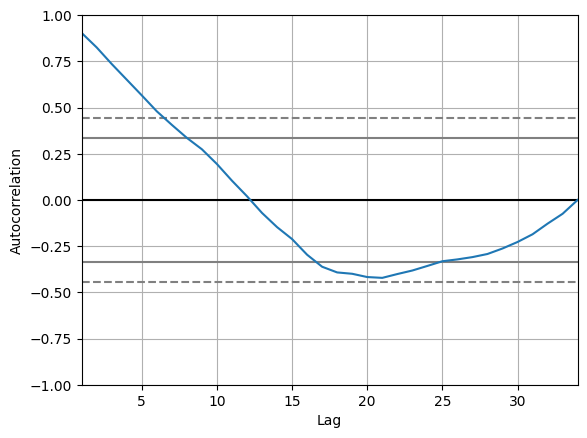

In [10]:

from pandas.plotting import lag_plot , autocorrelation_plot

c= autocorrelation_plot(df)
c

The autocorrelation did not cross 0 in the available data.


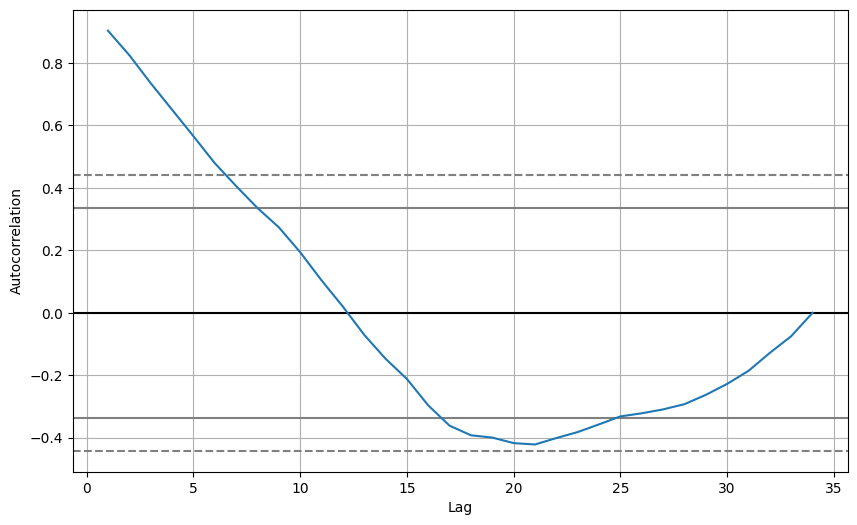

In [14]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

# Read the data
df = pd.read_parquet('data/base/Slovakia_GDP_(USD).parquet')
df = df.set_index('Year')
df.index = pd.to_datetime(df.index, format='%Y')
df = df.drop('Indicator', axis = 1)
df = df.dropna()

# Get autocorrelation values using pandas
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

# Plot autocorrelation and get values
fig, ax = plt.subplots(figsize=(10, 6))
c = autocorrelation_plot(df, ax=ax)

# Extract autocorrelation values (ignoring the first plot which is the data itself)
ac_values = [line.get_ydata() for line in ax.lines][0]

# Find the lag value where the autocorrelation crosses zero
crossing_lag = next((i for i, value in enumerate(ac_values) if value < 0), None)

if crossing_lag is not None:
    print(f"The autocorrelation crosses 0 at lag value {crossing_lag}")
else:
    print("The autocorrelation did not cross 0 in the available data.")


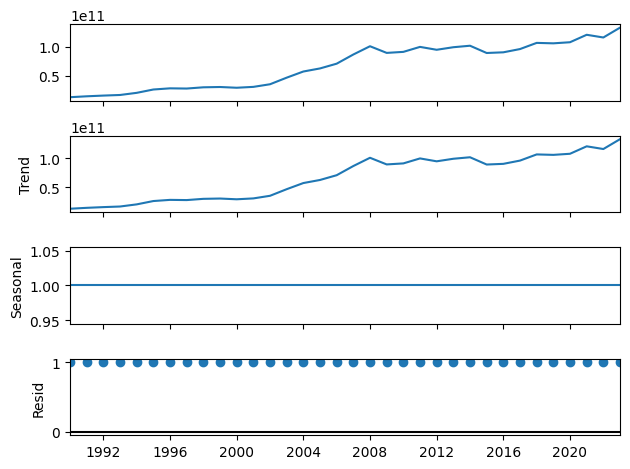

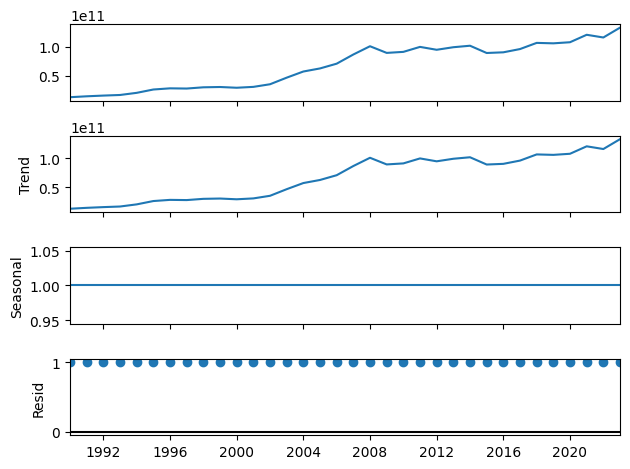

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative' , period=1)
result.plot()


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def save_plot(train, test_y, predictions, country, indicator, model_name):
    """Function to save the plot in both Indicators and Countries folders."""

    model_colors = {
    "ARIMA": "blue",
    "Holt_Winters": "yellow",
    "LSTM": "black",
    "XGBoost": "pink",
    "Prophet": "brown"
}

    # Plotting predicted vs actual
    plt.figure(figsize=(10, 6))
    if model_name == "Prophet":
        plt.plot(train['ds'], train['y'], label='Train Data', color='green', linestyle='--')
        plt.plot(test_y['ds'], test_y['y'], label='Actual', color='red', linestyle='--')
        plt.plot(test_y['ds'], predictions, label=f'Predicted({model_name})', color=f'{model_colors["Prophet"]}', 
                 linestyle='-', marker='o')
    else:
        plt.plot(train.index, train, label='Train Data', color='green', linestyle='--')
        plt.plot(test_y.index, test_y, label='Actual', color='red', linestyle='--')
        plt.plot(test_y.index, predictions, label=f'Predicted({model_name})', color=f'{model_colors[model_name]}', 
                 linestyle='-', marker='o')
    

    
    plt.title(f'Predicted({model_name}) vs Actual for {country} - {indicator}')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()

    # Create subfolder for the indicator if it doesn't exist
    indicator_folder = os.path.join('images', 'model_plot', 'Indicators', indicator)
    os.makedirs(indicator_folder, exist_ok=True)
    
    # Save the plot in the Indicators folder with dynamic model name
    plot_filename_indicator = os.path.join(indicator_folder, f'{model_name}_{country.replace(" ", "_")}_{indicator.replace(" ", "_")}.png')
    plt.savefig(plot_filename_indicator)

    # Create subfolder for the country if it doesn't exist
    country_folder = os.path.join('images', 'model_plot', 'Countries', country)
    os.makedirs(country_folder, exist_ok=True)
    
    # Save the same plot in the Countries folder with dynamic model name
    plot_filename_country = os.path.join(country_folder, f'{model_name}_{country.replace(" ", "_")}_{indicator.replace(" ", "_")}.png')
    plt.savefig(plot_filename_country)

    plt.close()

def train_xgboost(train_x, train_y, test_x, test_y,country,indicator):
    # Define the parameter grid for GridSearchCV
    top_n_features=4
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5]
    }

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(train_x, train_y)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Perform Recursive Feature Elimination (RFE)
    selector = RFE(estimator=best_model, n_features_to_select=top_n_features)
    selector = selector.fit(train_x, train_y)

    # Select the top N important features based on RFE
    selected_train_x = selector.transform(train_x)
    selected_test_x = selector.transform(test_x)

    # Train the model again with the selected features
    best_model.fit(selected_train_x, train_y)

    # Make predictions on the test set using the selected features
    predictions = best_model.predict(selected_test_x)

    save_plot(train_y, test_y, predictions, country, indicator, model_name="XGBoost")

    # Calculate the RMSE on the test set
    return np.sqrt(mean_squared_error(test_y, predictions)), predictions


def train_arima(train_y, test_y, country, indicator):
    best_rmse = float('inf')
    best_order = None
    best_predictions = None

    for p in range(4):
        for d in range(4):
            for q in range(4):
                try:
                    # Fit the ARIMA model
                    model = ARIMA(train_y, order=(p, d, q))
                    model_fit = model.fit()
                    
                    predictions = model_fit.forecast(steps=len(test_y))
                    rmse = np.sqrt(mean_squared_error(test_y, predictions))

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                        best_predictions = predictions
                except Exception as e:
                    continue

    # After finding the best model, save the predictions plot
    if best_predictions is not None:
        save_plot(train_y, test_y, best_predictions, country, indicator, model_name="ARIMA")

    return best_rmse , best_predictions


def train_prophet(train_df, test_y,country,indicator):
    #train_df['ds'] = pd.to_datetime(train_df['ds'])  # Ensure datetime format
    
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.1, 0.5],
        'seasonality_mode': ['additive', 'multiplicative'],
    }

    best_rmse = float('inf')
    best_params = None

    for changepoint_prior in param_grid['changepoint_prior_scale']:
        for seasonality_mode in param_grid['seasonality_mode']:
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=changepoint_prior,
                seasonality_mode=seasonality_mode
            )
            model.fit(train_df)

            future = model.make_future_dataframe(periods=len(test_y['y']), freq='Y')
            forecast = model.predict(future)
            predictions = forecast['yhat'].iloc[-len(test_y['y']):].values
            rmse = np.sqrt(mean_squared_error(test_y['y'], predictions))

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (changepoint_prior, seasonality_mode)

    # Train best model
    best_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=best_params[0],
        seasonality_mode=best_params[1]
    )
    best_model.fit(train_df)
    future = best_model.make_future_dataframe(periods=len(test_y['y']), freq='Y')
    forecast = best_model.predict(future)
    predictions = forecast['yhat'].iloc[-len(test_y['y']):].values

    save_plot(train_df, test_y, predictions, country, indicator, model_name="Prophet")
    return np.sqrt(mean_squared_error(test_y['y'], predictions)) , predictions

def train_holt_winters(train, test_y, country, indicator):
    param_grid = {
        'trend': [None, 'add', 'mul'],
        'seasonal': [None, 'add', 'mul'],
        'seasonal_periods': [None, 12]
    }

    best_rmse = float('inf')
    best_params = None

    for trend in param_grid['trend']:
        for seasonal in param_grid['seasonal']:
            for seasonal_periods in param_grid['seasonal_periods']:
                try:
                    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
                    fitted_model = model.fit()
                    predictions = fitted_model.forecast(len(test_y))
                    rmse = np.sqrt(mean_squared_error(test_y, predictions))

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (trend, seasonal, seasonal_periods)
                except:
                    continue

    best_model = ExponentialSmoothing(train, trend=best_params[0], seasonal=best_params[1], seasonal_periods=best_params[2])
    best_fitted_model = best_model.fit()
    predictions = best_fitted_model.forecast(len(test_y))
    
    # Call the save_plot function to save the plot
    save_plot(train, test_y, predictions, country, indicator, model_name="Holt_Winters")

    return np.sqrt(mean_squared_error(test_y, predictions)) , predictions



def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

def train_lstm(train, test_y, country, indicator, seq_length=5, epochs=50, batch_size=16):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_y.values.reshape(-1, 1))

    X_train, y_train = create_sequences(train_scaled, seq_length)

    # Define LSTM model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.3),
        LSTM(100, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])

    # **Rolling Prediction to Use Entire `test_y`**
    predictions = []
    input_seq = train_scaled[-seq_length:].tolist()  # Start with last known sequence

    for _ in range(len(test_y)):  # Predict for every step in test_y
        X_input = np.array(input_seq[-seq_length:]).reshape(1, seq_length, 1)
        y_pred = model.predict(X_input, verbose=0).flatten()[0]  # Predict next value
        predictions.append(y_pred)  # Store predicted value
        input_seq.append([y_pred])  # Append prediction to sequence for next step

    # Convert predictions back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Calculate RMSE using full `test_y`
    rmse = np.sqrt(mean_squared_error(test_y, predictions))

    # Save plot
    save_plot(train, test_y, predictions, country, indicator, model_name="LSTM")
    return rmse , predictions


with open("countries.json", "r") as f:
    country_names = json.load(f)

with open("indicators.json", "r") as f:
    indicators = json.load(f)

data_folder = "data/base"
model_errors_rmse = {}
log_data = []
country_indicators_plots = {}
for country, country_code in country_names.items():
    for indicator, indicator_code in indicators.items():
        filename = f"{country.replace(' ', '_')}_{indicator.replace(' ', '_')}.parquet"
        filepath = os.path.join(data_folder, filename)
        
        if os.path.exists(filepath):
            df = pd.read_parquet(filepath)
            if 'Year' in df.columns and 'Value' in df.columns:
                df = df.set_index('Year').sort_index()
                df.index = pd.to_datetime(df.index, format='%Y')
                df = df.dropna()
                df = df.drop('Indicator', axis = 1)
                df_original = df.copy()
                
                for lag in range(1, 6):  
                    df[f'lag_{lag}'] = df['Value'].shift(lag)
                
                df['expanding_mean'] = df['Value'].expanding().mean()
                df['expanding_std'] = df['Value'].expanding().std()
                df['expanding_max'] = df['Value'].expanding().max()
                df['expanding_min'] = df['Value'].expanding().min()
                
                window_size = 3  
                df['rolling_mean'] = df['Value'].rolling(window=window_size, min_periods=1).mean()
                df['rolling_std'] = df['Value'].rolling(window=window_size, min_periods=1).std()
                df['rolling_max'] = df['Value'].rolling(window=window_size, min_periods=1).max()
                df['rolling_min'] = df['Value'].rolling(window=window_size, min_periods=1).min()
                
                
                #df = df.dropna()
                train_size = int(len(df) * 0.8)
                
                train_xgb, test_xgb = df.iloc[:train_size], df.iloc[train_size:]
                feature_columns = ['rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min', 
                                   'expanding_mean', 'expanding_std', 'expanding_max', 'expanding_min',
                                   'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                train_x, train_y = train_xgb[feature_columns], train_xgb['Value']
                test_x, test_y = test_xgb[feature_columns], test_xgb['Value']
                
                model_errors_rmse[(country, indicator)] = {}
                model_errors_rmse[(country, indicator)]['XGBoost'], xgb_pred = train_xgboost(train_x, train_y, test_x, test_y , country,indicator)
                model_errors_rmse[(country, indicator)]['ARIMA'],arime_pred = train_arima(df_original.iloc[:train_size]['Value'], 
                                                                               df_original.iloc[train_size:]['Value'], 
                                                                               country,indicator)
                model_errors_rmse[(country, indicator)]['Holt-Winters'] , es_pred = train_holt_winters(df_original.iloc[:train_size]['Value'], 
                                                                                             df_original.iloc[train_size:]['Value'],
                                                                                             country,indicator)
                model_errors_rmse[(country, indicator)]['LSTM'] , lstm_pred = train_lstm(df_original.iloc[:train_size]['Value'], 
                                                                             df_original.iloc[train_size:]['Value'],
                                                                             country,indicator)


                prophet_train_df = df_original.iloc[:train_size].reset_index().rename(columns={'Year': 'ds', 'Value': 'y'})
                prophet_test_df = df_original.iloc[train_size:].reset_index().rename(columns={'Year': 'ds', 'Value': 'y'})
                prophet_train_df['ds'] = pd.to_datetime(prophet_train_df['ds'])
                prophet_test_df['ds'] = pd.to_datetime(prophet_test_df['ds'])
                model_errors_rmse[(country, indicator)]['Prophet'] , prop_error = train_prophet(prophet_train_df, prophet_test_df,
                                                                                   country,indicator)
                
                sorted_models = sorted(model_errors_rmse[(country, indicator)].items(), key=lambda x: x[1])
                log_current_data = []
                for rank, (model_name, rmse) in enumerate(sorted_models, start=1):
                    log_data.append([country, indicator, model_name, rmse, rank])
                    log_current_data.append([country, indicator, model_name, rmse, rank])

                
                model_ranks = {(entry[0], entry[1], entry[2]): entry[4] for entry in log_current_data}
                plt.figure(figsize=(10, 6))
                plt.plot(df_original.iloc[:train_size].index, df_original.iloc[:train_size]['Value'], 
                         label='Train Data', color='green', linestyle='--')
                plt.plot(df_original.iloc[train_size:].index, df_original.iloc[train_size:]['Value'],
                          label='Test Data', color='red', linestyle='--')
                
                plt.plot(df_original.iloc[train_size:].index, arime_pred, 
                         label=f'ARIMA ({model_ranks.get((country, indicator, "ARIMA"), "N/A")})', 
                         color='blue', linestyle='-', marker='o')
                
                plt.plot(df_original.iloc[train_size:].index, es_pred, 
                          label=f'Holt-Winters ({model_ranks.get((country, indicator, "Holt-Winters"), "N/A")})',
                         color='yellow',linestyle='-', marker='o')
                
                plt.plot(df_original.iloc[train_size:].index, lstm_pred, 
                         label=f'LSTM ({model_ranks.get((country, indicator, "LSTM"), "N/A")})', 
                         color='black', linestyle='-', marker='o')
                
                plt.plot(df_original.iloc[train_size:].index, xgb_pred, 
                         label=f'XGBoost ({model_ranks.get((country, indicator, "XGBoost"), "N/A")})', 
                         color='pink', linestyle='-', marker='o')
                
                plt.plot(df_original.iloc[train_size:].index, prop_error, 
                         label=f'Prophet ({model_ranks.get((country, indicator, "Prophet"), "N/A")})', 
                         color='brown', linestyle='-', marker='o')
                
                
                plt.title(f'Predicted vs Actual for {country} - {indicator}')
                plt.xlabel('Year')
                plt.ylabel('Value')
                plt.legend()

                # Create subfolder for the indicator if it doesn't exist
                indicator_folder = os.path.join('images', 'model_plot', 'Indicators', indicator)
                os.makedirs(indicator_folder, exist_ok=True)
                
                # Save the plot in the Indicators folder with dynamic model name
                plot_filename_indicator = os.path.join(indicator_folder, f'AllModels_{country.replace(" ", "_")}_{indicator.replace(" ", "_")}.png')
                plt.savefig(plot_filename_indicator)

                # Create subfolder for the country if it doesn't exist
                country_folder = os.path.join('images', 'model_plot', 'Countries', country)
                os.makedirs(country_folder, exist_ok=True)
                
                # Save the same plot in the Countries folder with dynamic model name
                plot_filename_country = os.path.join(country_folder, f'AllModels_{country.replace(" ", "_")}_{indicator.replace(" ", "_")}.png')
                plt.savefig(plot_filename_country)

                
                #plt.savefig(f'Predicted vs Actual for {country} - {indicator}')

                if country not in country_indicators_plots:
                    country_indicators_plots[country] = []
                country_indicators_plots[country].append(plt.gcf())
                plt.close()

# After collecting all plots for each country, create a combined plot
for country, plots in country_indicators_plots.items():
    n_plots = len(plots)
    n_cols = 2  # Set number of columns in the grid
    n_rows = (n_plots + 1) // n_cols  # Calculate required number of rows
    
    plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure size for grid layout
    for i, plot in enumerate(plots, start=1):
        plt.subplot(n_rows, n_cols, i)
        
        # Copy each plot's data by extracting from the original plot and plotting again
        for ax in plot.get_axes():  # Iterate through all axes in the current plot
            for line in ax.get_lines():  # Get lines (or other elements) from the original plot
                plt.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color(), linestyle=line.get_linestyle(), marker=line.get_marker())
        
        indicator_name = list(indicators.keys())[i - 1]
        plt.title(f'{country} - {indicator_name}')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()

    # Save the combined plot
    country_folder = os.path.join('images', 'model_plot', 'Countries', country)
    os.makedirs(country_folder, exist_ok=True)
    plot_filename_country = os.path.join(country_folder, f'AllIndicators_{country.replace(" ", "_")}.png')
    plt.tight_layout()
    plt.savefig(plot_filename_country)
    plt.close()

# Create a dictionary to store all indicator plots for later use
indicator_plots = {indicator: [] for indicator in indicators.keys()}

# After collecting all plots for each country, create a combined plot for each indicator
for country, plots in country_indicators_plots.items():
    for i, plot in enumerate(plots, start=1):
        indicator_name = list(indicators.keys())[i - 1]
        
        # Append each plot to the corresponding indicator's list
        indicator_plots[indicator_name].append(plot)

# Now create a combined plot for all countries for each indicator
for indicator, plots in indicator_plots.items():
    n_plots = len(plots)
    n_cols = 2  # Set number of columns in the grid
    n_rows = (n_plots + 1) // n_cols  # Calculate required number of rows
    
    plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure size for grid layout
    for i, plot in enumerate(plots, start=1):
        plt.subplot(n_rows, n_cols, i)
        
        # Copy each plot's data by extracting from the original plot and plotting again
        for ax in plot.get_axes():  # Iterate through all axes in the current plot
            for line in ax.get_lines():  # Get lines (or other elements) from the original plot
                plt.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color(), linestyle=line.get_linestyle(), marker=line.get_marker())
        
        plt.title(f'{indicator} - {list(country_names)[i-1]}')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()

    # Save the combined plot for the indicator across all countries
    indicator_folder = os.path.join('images', 'model_plot', 'Indicators', indicator)
    os.makedirs(indicator_folder, exist_ok=True)
    plot_filename_indicator = os.path.join(indicator_folder, f'AllCountries_{indicator.replace(" ", "_")}.png')
    plt.tight_layout()
    plt.savefig(plot_filename_indicator)
    plt.close()

log_df = pd.DataFrame(log_data, columns=['Country', 'Indicator', 'Model', 'RMSE', 'Rank'])
log_df.to_csv("model_error_log.csv", index=False)


c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, 

In [1]:
country_indicators_plots

NameError: name 'country_indicators_plots' is not defined

In [2]:
log_df.loc[log_df['Indicator']=="Inflation (CPI)",:]

Country        Indicator         Model       RMSE  Rank
10   Czech Republic  Inflation (CPI)       XGBoost   2.936785     1
11   Czech Republic  Inflation (CPI)         ARIMA   3.068765     2
12   Czech Republic  Inflation (CPI)  Holt-Winters   6.048436     3
13   Czech Republic  Inflation (CPI)          LSTM   6.091633     4
14   Czech Republic  Inflation (CPI)       Prophet   7.188270     5
45          Hungary  Inflation (CPI)       XGBoost   2.721282     1
46          Hungary  Inflation (CPI)         ARIMA   5.450300     2
47          Hungary  Inflation (CPI)  Holt-Winters   5.586125     3
48          Hungary  Inflation (CPI)       Prophet   5.689929     4
49          Hungary  Inflation (CPI)          LSTM   6.046953     5
80           Poland  Inflation (CPI)  Holt-Winters   4.485525     1
81           Poland  Inflation (CPI)       Prophet   4.493903     2
82           Poland  Inflation (CPI)         ARIMA   4.528208     3
83           Poland  Inflation (CPI)       XGBoost  12.945832     4
84           Poland  Inflation (CPI)          LSTM  47.430157     5
115        Slovakia  Inflation (CPI)         ARIMA   2.499848     1
116        Slovakia  Inflation (CPI)       XGBoost   4.750155     2
117        Slovakia  Inflation (CPI)  Holt-Winters   6.457854     3
118        Slovakia  Inflation (CPI)          LSTM   6.599315     4
119        Slovakia  Inflation (CPI)       Prophet   8.942961     5
150         Germany  Inflation (CPI)       XGBoost   0.771889     1
151         Germany  Inflation (CPI)         ARIMA   1.584830     2
152         Germany  Inflation (CPI)       Prophet   1.954567     3
153         Germany  Inflation (CPI)          LSTM   2.006697     4
154         Germany  Inflation (CPI)  Holt-Winters   2.233690     5
185         Austria  Inflation (CPI)         ARIMA   1.892595     1
186         Austria  Inflation (CPI)       XGBoost   1.993961     2
187         Austria  Inflation (CPI)          LSTM   2.219498     3
188         Austria  Inflation (CPI)       Prophet   2.403661     4
189         Austria  Inflation (CPI)  Holt-Winters   2.485334     5
220          France  Inflation (CPI)       XGBoost   0.931826     1
221          France  Inflation (CPI)         ARIMA   1.428492     2
222          France  Inflation (CPI)          LSTM   1.510612     3
223          France  Inflation (CPI)       Prophet   1.542932     4
224          France  Inflation (CPI)  Holt-Winters   1.582106     5
255           Italy  Inflation (CPI)       XGBoost   1.447552     1
256           Italy  Inflation (CPI)  Holt-Winters   1.729679     2
257           Italy  Inflation (CPI)         ARIMA   2.302643     3
258           Italy  Inflation (CPI)       Prophet   2.506138     4
259           Italy  Inflation (CPI)          LSTM   2.820816     5

In [2]:


# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
pivot_country_df = log_df.pivot_table(index=['Country', 'Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
pivot_country_df.columns = ['1', '2', '3','4','5']

# Reset index for clear visibility
pivot_country_df.reset_index(inplace=True)
pivot_country_df.to_csv("model_rankings_by_country_with_models.csv", index=False)

pivot_country_df

Country         Model  1  2  3  4  5
0          Austria         ARIMA  4  2  1  0  0
1          Austria  Holt-Winters  0  1  4  1  1
2          Austria          LSTM  1  1  1  1  3
3          Austria       Prophet  1  2  1  2  1
4          Austria       XGBoost  1  1  0  3  2
5   Czech Republic         ARIMA  3  4  0  0  0
6   Czech Republic  Holt-Winters  0  2  5  0  0
7   Czech Republic          LSTM  0  0  0  4  3
8   Czech Republic       Prophet  2  0  1  2  2
9   Czech Republic       XGBoost  2  1  1  1  2
10          France         ARIMA  3  3  1  0  0
11          France  Holt-Winters  0  3  3  0  1
12          France          LSTM  0  0  0  2  5
13          France       Prophet  2  1  2  2  0
14          France       XGBoost  2  0  1  3  1
15         Germany         ARIMA  3  4  0  0  0
16         Germany  Holt-Winters  1  2  3  0  1
17         Germany          LSTM  0  0  0  2  5
18         Germany       Prophet  1  1  2  2  1
19         Germany       XGBoost  2  0  2  3  0
20         Hungary         ARIMA  3  3  1  0  0
21         Hungary  Holt-Winters  0  2  3  2  0
22         Hungary          LSTM  0  0  1  0  6
23         Hungary       Prophet  1  1  2  2  1
24         Hungary       XGBoost  3  1  0  3  0
25           Italy         ARIMA  2  3  2  0  0
26           Italy  Holt-Winters  0  3  2  1  1
27           Italy          LSTM  1  0  2  0  4
28           Italy       Prophet  0  0  1  5  1
29           Italy       XGBoost  4  1  0  1  1
30          Poland         ARIMA  1  2  3  1  0
31          Poland  Holt-Winters  1  3  2  1  0
32          Poland          LSTM  0  1  1  4  1
33          Poland       Prophet  4  1  1  0  1
34          Poland       XGBoost  1  0  0  1  5
35        Slovakia         ARIMA  6  1  0  0  0
36        Slovakia  Holt-Winters  0  2  2  3  0
37        Slovakia          LSTM  0  1  3  1  2
38        Slovakia       Prophet  1  2  1  0  3
39        Slovakia       XGBoost  0  1  1  3  2

In [3]:
# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
pivot_df = log_df.pivot_table(index=['Indicator', 'Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
pivot_df.columns = ['1', '2', '3','4','5']

# Reset index for clear visibility
pivot_df.reset_index(inplace=True)
pivot_df.to_csv("model_rankings_by_indicator_with_models.csv", index=False)

pivot_df

Indicator         Model  1  2  3  4  5
0   Exports of goods and services (% of GDP)         ARIMA  3  4  1  0  0
1   Exports of goods and services (% of GDP)  Holt-Winters  1  3  3  1  0
2   Exports of goods and services (% of GDP)          LSTM  0  1  0  1  6
3   Exports of goods and services (% of GDP)       Prophet  3  0  1  3  1
4   Exports of goods and services (% of GDP)       XGBoost  1  0  3  3  1
5                                  GDP (USD)         ARIMA  4  3  0  1  0
6                                  GDP (USD)  Holt-Winters  0  3  4  1  0
7                                  GDP (USD)          LSTM  0  0  2  1  5
8                                  GDP (USD)       Prophet  3  2  1  2  0
9                                  GDP (USD)       XGBoost  1  0  1  3  3
10                     GDP growth (annual %)         ARIMA  4  4  0  0  0
11                     GDP growth (annual %)  Holt-Winters  0  1  5  2  0
12                     GDP growth (annual %)          LSTM  0  0  2  5  1
13                     GDP growth (annual %)       Prophet  0  2  1  0  5
14                     GDP growth (annual %)       XGBoost  4  1  0  1  2
15                      GDP per Capita (USD)         ARIMA  4  3  1  0  0
16                      GDP per Capita (USD)  Holt-Winters  0  2  5  1  0
17                      GDP per Capita (USD)          LSTM  0  1  0  2  5
18                      GDP per Capita (USD)       Prophet  2  2  2  2  0
19                      GDP per Capita (USD)       XGBoost  2  0  0  3  3
20  Imports of goods and services (% of GDP)         ARIMA  1  4  3  0  0
21  Imports of goods and services (% of GDP)  Holt-Winters  0  3  4  1  0
22  Imports of goods and services (% of GDP)          LSTM  2  0  1  1  4
23  Imports of goods and services (% of GDP)       Prophet  4  0  0  3  1
24  Imports of goods and services (% of GDP)       XGBoost  1  1  0  3  3
25                           Inflation (CPI)         ARIMA  2  4  2  0  0
26                           Inflation (CPI)  Holt-Winters  1  1  2  1  3
27                           Inflation (CPI)          LSTM  0  0  2  3  3
28                           Inflation (CPI)       Prophet  0  1  2  3  2
29                           Inflation (CPI)       XGBoost  5  2  0  1  0
30                     Unemployment Rate (%)         ARIMA  7  0  1  0  0
31                     Unemployment Rate (%)  Holt-Winters  0  5  1  1  1
32                     Unemployment Rate (%)          LSTM  0  1  1  1  5
33                     Unemployment Rate (%)       Prophet  0  1  4  2  1
34                     Unemployment Rate (%)       XGBoost  1  1  1  4  1

In [5]:
# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
overall_df = log_df.pivot_table(index=['Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
overall_df.columns = ['1', '2', '3','4','5']

# Reset index for clear visibility
overall_df.reset_index(inplace=True)
overall_df.to_csv("model_rankings_overall_placements.csv", index=False)

overall_df

Model   1   2   3   4   5
0         ARIMA  25  22   8   1   0
1  Holt-Winters   2  18  24   8   4
2          LSTM   2   3   8  14  29
3       Prophet  12   8  11  15  10
4       XGBoost  15   5   5  18  13